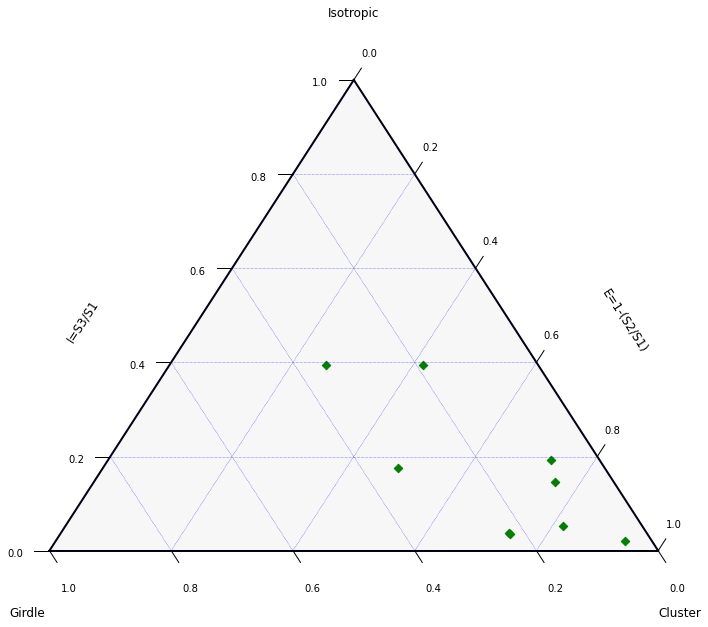

In [1]:
import os
import glob2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplstereonet
import ternary as te
from numpy.linalg import eigh

def read_csv_file(file_path):
    """Read a CSV file and return a Pandas DataFrame."""
    return pd.read_csv(file_path)

def calculate_direction_cosines(Trend, Plunge):
    """Calculate direction cosines and return them as arrays."""
    a = np.cos(np.radians(Trend))
    b = np.cos(np.radians(Plunge))
    c = np.sin(np.radians(Trend))
    xi = (a * b).round(4)
    yi = (c * b).round(4)
    zi = np.sin(np.radians(Plunge)).round(4)
    return xi, yi, zi

def plot_stereonet_and_rose(Trend, Plunge, output_filename, V1_azi, V1_plunge):
    """Create stereonet and rose diagram plots."""
    fig = plt.figure(figsize=(12, 12))         #creates an empty figure with no Axes

    # Stereonet
    ax1 = fig.add_subplot(221, projection='stereonet')
    ax1.line(Plunge, Trend, 'o', color='blue')
    # Add an X at V1_azi, V1_plunge
    ax1.line(V1_plunge, V1_azi, 'rx', markersize=10, label='V1')
    ax1.set_title(f'a-axis on stereonet - Fabric Demo', y=1.10, fontsize=15)
    ax1._polar.set_position(ax1.get_position()) #manually matches any size changes that have occurred in the parent axis
    ax1.grid()

    # Prepare data to build rose diagrams
    bin_edges = np.arange(-5, 366, 10)
    trends_in_bins, _ = np.histogram(Trend, bin_edges)
    Trends = trends_in_bins[0:-1]  # Calculate Trends here

    # Rose diagram
    ax2 = fig.add_subplot(222, projection='polar')
    ax2.set_title('a-axis on rose diagram', y=1.10, fontsize=15)
    ax2.bar(np.deg2rad(np.arange(0, 360, 10)), Trends, width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
    ax2.set_theta_zero_location('N')
    ax2.set_theta_direction(-1)
    ax2.set_thetagrids(np.arange(0, 360, 30), labels=np.arange(0, 360, 30))
    ax2.set_rgrids(np.arange(1, Trends.max() + 4, 3), angle=0, weight= 'black')

    # Stereonet with kamb density
    ax3 = fig.add_subplot(223, projection='stereonet')
    ax3.line(Plunge, Trend, 'o', color='blue')
    m=ax3.density_contourf(Plunge, Trend, measurement='lines', cmap='Reds') #exponential_kamb is the default method
    ax3.set_title('with kamb density contours', y=1.05, fontsize=15)
    fig.colorbar(m) 

    for ax in [ax1]:
        note = f"n={Plunge.size} \nMean Plunge: {Plunge.mean():.1f}"
        ax.annotate(note, xy=(5 * 60, -30), xycoords='axes points')
        
        
    plt.savefig(output_filename)
    plt.close()

def main():
    data_directory = r'C:\Users\path_to_file'
    os.chdir(data_directory)
    
    filelist = glob2.glob('*.csv')
    
    # Initialize lists to store E, I, and R values
    all_E = []
    all_I = []
    all_R = []
    
    for index, file_path in enumerate(filelist):
        df = read_csv_file(file_path)
        
        Trend = df['Trend'].values
        Plunge = df['Plunge'].values

        output_filename = f'Output_{file_path[:-4]}.png'
        
        #Returns 1-D arrays for plunge and trend (eigenvectors converted to spherical coordinates), and normalized eigenvalues
        plu, azi, vals = mplstereonet.eigenvectors(Plunge, Trend, measurement='lines') 
        
        V1_azi=azi[0].round(1)
        V1_plunge=plu[0].round(1)
        V2_azi=azi[1].round(1)
        V2_plunge=plu[1].round(1)
        V3_azi=azi[2].round(1)
        V3_plunge=plu[2].round(1)
        
        #Pass the V1 values by calling the plot_stereonet_and_rose function to add V1 to stereonets
        plot_stereonet_and_rose(Trend, Plunge, output_filename, V1_azi, V1_plunge)
        
        X = np.concatenate(calculate_direction_cosines(Trend, Plunge)).reshape(3, Trend.shape[0])
        XT = X.T
        A = np.dot(X, XT).round(4)
        Ei = eigh(A)
        
        #For eigenvalues, it is better to use numpy
        Eighv = Ei[0]
        S1 = Eighv[2] / Trend.shape
        S2 = Eighv[1] / Trend.shape
        S3 = Eighv[0] / Trend.shape

        # Calculate E, I, and R values
        E = (1 - (S2 / S1)).round(4)
        I = (S3 / S1).round(4)
        R = (1 - (E + I)).round(4)
        
        # Add the calculated values to the lists
        all_E.extend(E)  # Use extend to add individual values
        all_I.extend(I)
        all_R.extend(R)

        #Create a Pandas dataframe of selected outputs
        output_df = pd.DataFrame(columns=['V1_trend', 'V1_plunge', 'E','I', 'R', 'S1', 'S2', 'S3'])
        output_df.loc[0] = [V1_azi, V1_plunge, E, I, R, S1, S2, S3]
        
        #To specify the Dtype is 'float'
        output_df['E']=output_df['E'].astype('float')      
        output_df['I']=output_df['I'].astype('float')
        output_df['R']=output_df['R'].astype('float')
        output_df['S1']=output_df['S1'].astype('float')
        output_df['S2']=output_df['S2'].astype('float')
        output_df['S3']=output_df['S3'].astype('float')

        # Export the DataFrame as a CSV
        output_csv_filename = f'Output_{file_path[:-4]}.csv'
        output_df.to_csv(output_csv_filename, index=False)
        
    # Create a ternary diagram outside of the loop
    scale = 1.0
    figure, fabric = te.figure(scale=scale)
    figure.set_size_inches(12, 10)
    
    # Plot the data
    data_points = np.vstack([all_E, all_I, all_R]).T
    fabric.scatter(data_points, marker='D', color='green', label="Green Diamonds")
    
    # Draw Boundary and Gridlines
    fabric.boundary(linewidth=2.0)
    fabric.gridlines(color="blue", multiple=0.2)
    
    # Set Axis labels
    fontsize = 12
    offset = 0.2
    fabric.left_axis_label("I=S3/S1", fontsize=fontsize, offset=0.2)
    fabric.right_axis_label("E=1-(S2/S1)", fontsize=fontsize, offset=0.2)
    fabric.top_corner_label("Isotropic", fontsize=fontsize, offset=0.25)
    fabric.right_corner_label("Cluster", fontsize=fontsize, offset=-0.05)
    fabric.left_corner_label("Girdle", fontsize=fontsize, offset=-0.05)

    # Configure the style of the axes and ticks and specify their orientation/sense
    fabric.ticks(axis='lbr', multiple=0.2, linewidth=1, offset=0.025, tick_formats="%.1f", clockwise=True)
    fabric.get_axes().axis('off')
    fabric.clear_matplotlib_ticks()

    fabric.show()

if __name__ == "__main__":
    main()
